# Setting the Environment seed

In [2]:
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing import image
import keras
import glob

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Loading the Image Data

In [3]:
dir_name='../input/the-oxfordiiit-pet-dataset/images/*'
#not sure what's going on with directory names in Kaggle, but needed the asterik to get it to work with glob

pets_files = glob.glob(dir_name) 
pets_df = pd.DataFrame(pets_files)
pets_df.columns =['full_path']
pets_df['file_name'] = pets_df['full_path'].str.split('images/').str[1]

# labels in this dataset are in the file name
pets_df['label'] = pets_df['file_name'].str.rsplit('_',1).str[0]
pets_df.tail()

,full_path,file_name,label
7389,../input/the-oxfordiiit-pet-dataset/images/bas...,basset_hound_30.jpg,basset_hound
7390,../input/the-oxfordiiit-pet-dataset/images/sai...,saint_bernard_70.jpg,saint_bernard
7391,../input/the-oxfordiiit-pet-dataset/images/gre...,great_pyrenees_65.jpg,great_pyrenees
7392,../input/the-oxfordiiit-pet-dataset/images/Sia...,Siamese_162.jpg,Siamese
7393,../input/the-oxfordiiit-pet-dataset/images/sai...,saint_bernard_131.jpg,saint_bernard


In [4]:
classNames = pets_df.label.unique()

In [5]:
%%time
datagen = image.ImageDataGenerator(rescale=1/255., validation_split=0.2)
train_generator = datagen.flow_from_dataframe(dataframe=pets_df, 
                                              directory= '../input/the-oxfordiiit-pet-dataset/images/images',
                                              #again not sure what's up with directories, took awhile to figure out I needed that ending /images
                                             x_col='file_name',
                                             y_col='label',
                                             target_size=(224,224),
                                             class_mode='categorical',
                                             batch_size=100,
                                             subset='training'
                                             )

validation_generator = datagen.flow_from_dataframe(dataframe=pets_df,
                                                   directory= '../input/the-oxfordiiit-pet-dataset/images/images',
                                                   x_col='file_name',                                                   
                                             y_col='label',
                                             target_size=(224,224),
                                             class_mode='categorical',
                                             batch_size=50,
                                             subset='validation',
                                             seed=7)


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 5 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 5912 validated image filenames belonging to 37 classes.
Found 1477 validated image filenames belonging to 37 classes.
CPU times: user 409 ms, sys: 393 ms, total: 801 ms
Wall time: 21.1 s


# Convolution Models: 

In [6]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Conv2D,MaxPooling2D,Dense
model = Sequential()
model.add(Conv2D(64 , (3,3) , input_shape=(224,224,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.3))

model.add(Conv2D(512 , (3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.3))

model.add(Conv2D(256, (3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.3))

model.add(Conv2D(128 , (3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.3))

model.add(Conv2D(64 , (3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(37,activation='softmax')) # 37 classes


model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()


2022-02-22 03:43:05.332432: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 512)     295424    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 512)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 54, 54, 512)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 256)       1

2022-02-22 03:43:05.451948: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 03:43:05.452680: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 03:43:05.454229: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-22 03:43:05.455529: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [7]:
history = model.fit(
        train_generator,
        validation_data= validation_generator,
        epochs=20,
    )

2022-02-22 03:43:08.844395: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-02-22 03:43:11.664450: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


60/60 [==============================] - 102s 2s/step - loss: 3.6217 - accuracy: 0.0272 - val_loss: 3.6110 - val_accuracy: 0.0366
Epoch 2/20
60/60 [==============================] - 60s 991ms/step - loss: 3.6124 - accuracy: 0.0276 - val_loss: 3.6108 - val_accuracy: 0.0393
Epoch 3/20
60/60 [==============================] - 61s 1s/step - loss: 3.6094 - accuracy: 0.0288 - val_loss: 3.6109 - val_accuracy: 0.0203
Epoch 4/20
60/60 [==============================] - 61s 1s/step - loss: 3.6063 - accuracy: 0.0323 - val_loss: 3.6103 - val_accuracy: 0.0203
Epoch 5/20
60/60 [==============================] - 56s 931ms/step - loss: 3.6041 - accuracy: 0.0362 - val_loss: 3.6101 - val_accuracy: 0.0244
Epoch 6/20
60/60 [==============================] - 54s 901ms/step - loss: 3.5996 - accuracy: 0.0345 - val_loss: 3.6092 - val_accuracy: 0.0278
Epoch 7/20
60/60 [==============================] - 54s 901ms/step - loss: 3.5957 - accuracy: 0.0369 - val_loss: 3.6073 - val_accuracy: 0.0278
Epoch 8/20
60/60 [

In [8]:
df_ = pd.DataFrame(history.history)
for value in df_:
    min_ = min(df_[value])
    max_ = max(df_[value])
    
    print(f'{value}:')
    print()
    print(f'Min {value} - {min_}; Max {value} - {max_}')

loss:

Min loss - 3.392714262008667; Max loss - 3.6217405796051025
accuracy:

Min accuracy - 0.02723274752497673; Max accuracy - 0.08728010952472687
val_loss:

Min val_loss - 3.488499164581299; Max val_loss - 3.610966444015503
val_accuracy:

Min val_accuracy - 0.020311441272497177; Max val_accuracy - 0.077860526740551


## Predictions 

Predicted Class: British_Shorthair
Correct Class : newfoundland


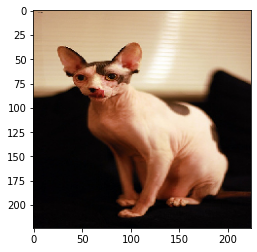

In [9]:
X_test, y_test = next(validation_generator)
y_proba = model.predict(X_test)
for i in range(len(y_proba)):
    classFinal = y_proba[0].argmax()
    print(f'Predicted Class: {classNames[classFinal]}')
    print(f'Correct Class : {classNames[y_test[i].argmax()]}')
    plt.imshow(X_test[i])
    break

### Trying a simpler cnn model

In [10]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Conv2D,MaxPooling2D,Dense

model = Sequential()
model.add(Conv2D(64 , (3,3) , input_shape=(224,224,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.3))

model.add(Conv2D(64 , (3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
          
model.add(Flatten())
model.add(Dense(37,activation='softmax')) # 37 classes

model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 186624)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 37)               

In [11]:
%%time
history = model.fit(
        train_generator,
        validation_data= validation_generator,
        epochs=10,
    )

Epoch 1/10
60/60 [==============================] - 45s 738ms/step - loss: 3.5911 - accuracy: 0.0489 - val_loss: 3.5526 - val_accuracy: 0.0481
Epoch 2/10
60/60 [==============================] - 43s 725ms/step - loss: 3.4665 - accuracy: 0.0753 - val_loss: 3.4814 - val_accuracy: 0.0643
Epoch 3/10
60/60 [==============================] - 44s 735ms/step - loss: 3.3871 - accuracy: 0.0924 - val_loss: 3.4381 - val_accuracy: 0.0731
Epoch 4/10
60/60 [==============================] - 44s 729ms/step - loss: 3.3074 - accuracy: 0.1130 - val_loss: 3.4027 - val_accuracy: 0.0988
Epoch 5/10
60/60 [==============================] - 43s 724ms/step - loss: 3.2443 - accuracy: 0.1292 - val_loss: 3.3654 - val_accuracy: 0.1063
Epoch 6/10
60/60 [==============================] - 44s 734ms/step - loss: 3.1639 - accuracy: 0.1436 - val_loss: 3.3035 - val_accuracy: 0.1205
Epoch 7/10
60/60 [==============================] - 43s 722ms/step - loss: 3.1159 - accuracy: 0.1612 - val_loss: 3.2633 - val_accuracy: 0.1286

In [12]:
df_ = pd.DataFrame(history.history)
for value in df_:
    min_ = min(df_[value])
    max_ = max(df_[value])
    
    print(f'{value}:')
    print()
    print(f'Min {value} - {min_}; Max {value} - {max_}')

loss:

Min loss - 2.9310789108276367; Max loss - 3.591110944747925
accuracy:

Min accuracy - 0.048883628100156784; Max accuracy - 0.20365358889102936
val_loss:

Min val_loss - 3.219451427459717; Max val_loss - 3.552574396133423
val_accuracy:

Min val_accuracy - 0.04807041212916374; Max val_accuracy - 0.13270142674446106


In [13]:
train_generator[0][0].shape

(100, 224, 224, 3)

## Predictions 

Predicted Class: saint_bernard
Correct Class : yorkshire_terrier


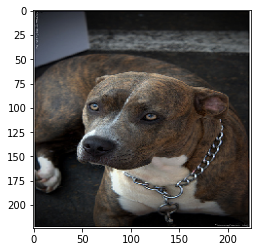

In [14]:
X_test, y_test = next(validation_generator)
y_proba = model.predict(X_test)
for i in range(len(y_proba)):
    classFinal = y_proba[0].argmax()
    print(f'Predicted Class: {classNames[classFinal]}')
    print(f'Correct Class : {classNames[y_test[i].argmax()]}')
    plt.imshow(X_test[i])
    break

# Transfer Learning:

We'll be using the: 
- mobilenet_v2
- inception_v3
- resnet50 

pretrained models from the tensorflow hub to fit our dataset and compare it with the earlier CNN model results.

In [15]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"
resnset50 = 'https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5'

classifier_model = {'mobilenet_v2':mobilenet_v2, 'inception_v3':inception_v3,'resnset50':resnset50}

In [16]:
%%time
histories = {}
for name in classifier_model:
    pretrained_base = hub.KerasLayer(classifier_model[name], trainable = False) #input_shape=IMAGE_SHAPE+(3,))
    model = keras.Sequential([
        pretrained_base,
        keras.layers.Flatten(),
        keras.layers.Dense(128,activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64,activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(37, activation='softmax'), 
    ])
    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=['accuracy'],
    )
    history = model.fit(
        train_generator,
        validation_data= validation_generator,
        epochs=10,
    )
    histories[name] = history
    

Epoch 1/10
60/60 [==============================] - 50s 782ms/step - loss: 2.1338 - accuracy: 0.4229 - val_loss: 0.5854 - val_accuracy: 0.8450
Epoch 2/10
60/60 [==============================] - 44s 732ms/step - loss: 0.8566 - accuracy: 0.7395 - val_loss: 0.4048 - val_accuracy: 0.8761
Epoch 3/10
60/60 [==============================] - 44s 739ms/step - loss: 0.6224 - accuracy: 0.8024 - val_loss: 0.3622 - val_accuracy: 0.8903
Epoch 4/10
60/60 [==============================] - 51s 846ms/step - loss: 0.4859 - accuracy: 0.8500 - val_loss: 0.3316 - val_accuracy: 0.8998
Epoch 5/10
60/60 [==============================] - 48s 805ms/step - loss: 0.4175 - accuracy: 0.8672 - val_loss: 0.3295 - val_accuracy: 0.8930
Epoch 6/10
60/60 [==============================] - 46s 777ms/step - loss: 0.3735 - accuracy: 0.8801 - val_loss: 0.3509 - val_accuracy: 0.8951
Epoch 7/10
60/60 [==============================] - 44s 728ms/step - loss: 0.3185 - accuracy: 0.8980 - val_loss: 0.3419 - val_accuracy: 0.8910

In [17]:
for history in histories: 
    df = pd.DataFrame(histories[history].history)
    print(f'{history}')
    print(df)

mobilenet_v2
       loss  accuracy  val_loss  val_accuracy
0  2.133827  0.422869  0.585395      0.844956
1  0.856573  0.739513  0.404794      0.876100
2  0.622429  0.802436  0.362166      0.890318
3  0.485892  0.849966  0.331616      0.899797
4  0.417509  0.867219  0.329473      0.893026
5  0.373515  0.880074  0.350939      0.895058
6  0.318483  0.898004  0.341889      0.890995
7  0.291034  0.906800  0.351223      0.896412
8  0.260873  0.916610  0.347788      0.893703
9  0.253965  0.922869  0.376626      0.895058
inception_v3
       loss  accuracy  val_loss  val_accuracy
0  2.075338  0.467355  0.656669      0.835477
1  0.857811  0.752537  0.462801      0.864590
2  0.635921  0.816137  0.447064      0.866622
3  0.521662  0.841001  0.424413      0.880162
4  0.457026  0.860453  0.411941      0.888287
5  0.390739  0.875000  0.406507      0.889641
6  0.368885  0.888701  0.416449      0.882194
7  0.315547  0.898850  0.429117      0.881517
8  0.304341  0.895974  0.410324      0.890995
9  0.265

In [22]:
for history in histories: 
    df = pd.DataFrame(histories[history].history)
    print(history)
    for value in df:
        min_ = min(df[value])
        max_ = max(df[value])
        print(f'{value}:')
        print(f'Min {value} - {min_}; Max {value} - {max_}')
    print()
    print()

mobilenet_v2
loss:
Min loss - 0.2539646029472351; Max loss - 2.1338272094726562
accuracy:
Min accuracy - 0.4228687286376953; Max accuracy - 0.9228687286376953
val_loss:
Min val_loss - 0.3294725716114044; Max val_loss - 0.5853949785232544
val_accuracy:
Min val_accuracy - 0.8449559807777405; Max val_accuracy - 0.8997969031333923


inception_v3
loss:
Min loss - 0.2656388282775879; Max loss - 2.0753376483917236
accuracy:
Min accuracy - 0.46735453605651855; Max accuracy - 0.9106901288032532
val_loss:
Min val_loss - 0.4003170132637024; Max val_loss - 0.6566694974899292
val_accuracy:
Min val_accuracy - 0.8354772925376892; Max val_accuracy - 0.8930264115333557


resnset50
loss:
Min loss - 0.3441206216812134; Max loss - 2.2976226806640625
accuracy:
Min accuracy - 0.4054465591907501; Max accuracy - 0.883457362651825
val_loss:
Min val_loss - 0.34409210085868835; Max val_loss - 0.6993129849433899
val_accuracy:
Min val_accuracy - 0.8171970248222351; Max val_accuracy - 0.9018280506134033




Predicted Class: american_pit_bull_terrier
Correct Class : american_pit_bull_terrier


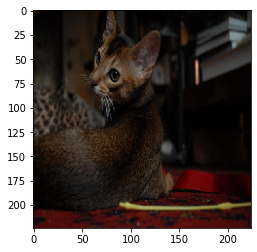

In [19]:
X_test, y_test = next(validation_generator)
y_proba = model.predict(X_test)
for i in range(len(y_proba)):
    classFinal = y_proba[0].argmax()
    print(f'Predicted Class: {classNames[classFinal]}')
    print(f'Correct Class : {classNames[y_test[i].argmax()]}')
    plt.imshow(X_test[i])
    break

## Comparing the Accuracies :
For Convolutions: 
We observed the _ layered CNN was giving a lower accuracy than the smaller CNN, so just increasing the number of layers is not always the right answer, the right answer might be much simpler than you think.

For Transfer Learning Models: 
All 3 models have a high validation accuracy close to 90 percent, but resnet50 reached more than 90% so maybe we can select it train it using callback to get the best model.